1-预处理数据：《数据融合》


2-基于余弦相似度:构建《相似度约束函数》。实验以证明，其具有2点性质：（1）同类相似度最大化；（2）异类相似度最小化；


3-把上述《相似度约束函数》应用于滚动轴承故障识别，以证明其可以提高《准确率》

In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import time

print(tf.__version__)

gpus = tf.config.list_physical_devices(device_type='GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except:
    print('Error!')
    pass

2.6.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import time
def get_date():
    now_time = list(time.localtime(time.time()))
    date = '_TIME'
    for i,item in enumerate(time.localtime(time.time())):
        date = date + '_' + str(item)
        if i==2:
            date = date + '__'
        if i==4:
            date = date + '__'
        if i > 5: break
    return date
get_date()

'_TIME_2022_3_9___21_11___34_2'

# 加载数据

In [3]:
dp = 'F:\\Data\\PHME16'
all_bearing_names = os.listdir(dp)
print(all_bearing_names)

normal_bearings = ['K001','K002','K003','K004','K005']
outer_bearings  = ['KA04','KA15','KA16','KA22','KA30']
inner_bearings  = ['KI04','KI14','KI16','KI18','KI21']


def find_exist_bearings(bearings):
    exist_bearings = []
    for name in all_bearing_names:
        if name in bearings:
            exist_bearings.append(name)
    return exist_bearings
find_exist_bearings(normal_bearings), find_exist_bearings(outer_bearings), find_exist_bearings(inner_bearings) 

['20160703_PHME16_CM_bearing.pdf', 'csv', 'data_structure.m', 'desktop.ini', 'K001', 'K002', 'K003', 'K004', 'K005', 'KA01', 'KA03', 'KA04', 'KA15', 'KA16', 'KA22', 'KA30', 'KB23', 'KB24', 'KB27', 'KI01', 'KI04', 'KI14', 'KI16', 'KI18', 'KI21', 'matlab-画图.docx', 'wode.docx', '~$tlab-画图.docx', '压缩包']


(['K001', 'K002', 'K003', 'K004', 'K005'],
 ['KA04', 'KA15', 'KA16', 'KA22', 'KA30'],
 ['KI04', 'KI14', 'KI16', 'KI18', 'KI21'])

工况共有4种：

A：N15_M01_F10

B：N09_M07_F10

C：N15_M07_F04

D：N15_M07_F10

In [4]:
def find_mat_names(bearing):
    mat_names = []
    bearing_path = dp + '\\' +bearing
    all_names = os.listdir(bearing_path)
    for name in all_names:
        if 'mat' in name:
            #  N15_M01_F10,  N09_M07_F10,  N15_M07_F04,  N15_M07_F10
            if 'N09_M07_F10'  in name:
                mat_names.append(name)
    return bearing_path, mat_names

bearing_path, mat_names = find_mat_names('K001')
bearing_path, len(mat_names),mat_names[::10]

('F:\\Data\\PHME16\\K001',
 20,
 ['N09_M07_F10_K001_1.mat', 'N09_M07_F10_K001_19.mat'])

In [5]:
def load_mat(bearing_path,mat_name):
    mat_path = bearing_path + '\\' + mat_name
    print(mat_path)
    mat = scipy.io.loadmat(mat_path)
    return mat


La = 4*64000
L = 80*80
num = La//L
print(La,L,num,num*L)

256000 6400 40 256000


In [6]:
num = 10

def parse_mat(mat):
    '''输入mat，返回c1,c2,v，
    采样频率64KHz，采样时间4S，因此应该有64K*4个数据点,
     每个C1、C2、V都是以64K的采样率，采样4秒，故采样点数4*64K
    按照每个样本长度=1.5圈*4266点/圈，约6400点划分样本，得40个样本'''
    for key in mat.keys():
        if 'K' in key:
            datakey = key
    matdata = mat[datakey][0][0]
    [info,X,Y,Desc] = matdata
    [info,X,Y,Desc] = [x[0] for x in [info,X,Y,Desc]]
    c1 = Y[1][2].reshape(-1) / 3.0
    c2 = Y[2][2].reshape(-1) / 3.0
    v  = Y[6][2].reshape(-1) / 10.0
    c1c2v = np.stack([c1,c2,v],axis=-1)
    
    s = 0
    c1c2v = c1c2v[s:s+num*L,:]
    c1c2v = c1c2v.reshape(-1,80*80,3)
    return c1c2v

In [7]:
def get_c1_c2_v_of_one_type(bearings):
    '''bearings = normal_bearings/outer_bearings/inner_bearings'''
    c1c2v_samples = []
    for bearing in bearings:
        '''一类轴承中的某一个轴承，如所有外圈故障轴承中的KA04'''
        bearing_path, mat_names = find_mat_names(bearing)
        print(bearing_path,'contain', len(mat_names), 'mat file',sep = '  ')
        for mat_name in mat_names:
            '''某个轴承在4种不同工况各有20次实验，取4*20个实验中的某一个实验采集到的mat'''
            mat = load_mat(bearing_path,mat_name)
            c1c2v = parse_mat(mat)
            c1c2v_samples.append(c1c2v)
        
        print('One bearing mat files has been read.','\n\n')
    data = np.concatenate(c1c2v_samples)
    return data

normal_data_128 = get_c1_c2_v_of_one_type(normal_bearings)
outer_data_128 = get_c1_c2_v_of_one_type(outer_bearings)
inner_data_128 = get_c1_c2_v_of_one_type(inner_bearings)

F:\Data\PHME16\K001  contain  20  mat file
F:\Data\PHME16\K001\N09_M07_F10_K001_1.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_10.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_11.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_12.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_13.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_14.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_15.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_16.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_17.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_18.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_19.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_2.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_20.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_3.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_4.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_5.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_6.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_7.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_8.mat
F:\Data\PHME16\K001\N09_M07_F10_K001_9.mat
One bearing mat files has been read. 


F:\Data\PHME16\K002  contain  20  mat file
F:\

One bearing mat files has been read. 


F:\Data\PHME16\KA30  contain  20  mat file
F:\Data\PHME16\KA30\N09_M07_F10_KA30_1.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_10.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_11.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_12.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_13.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_14.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_15.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_16.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_17.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_18.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_19.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_2.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_20.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_3.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_4.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_5.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_6.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_7.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_8.mat
F:\Data\PHME16\KA30\N09_M07_F10_KA30_9.mat
One bearing mat files has been read. 


F:\Dat

In [8]:
normal_data_128.shape

(1000, 6400, 3)

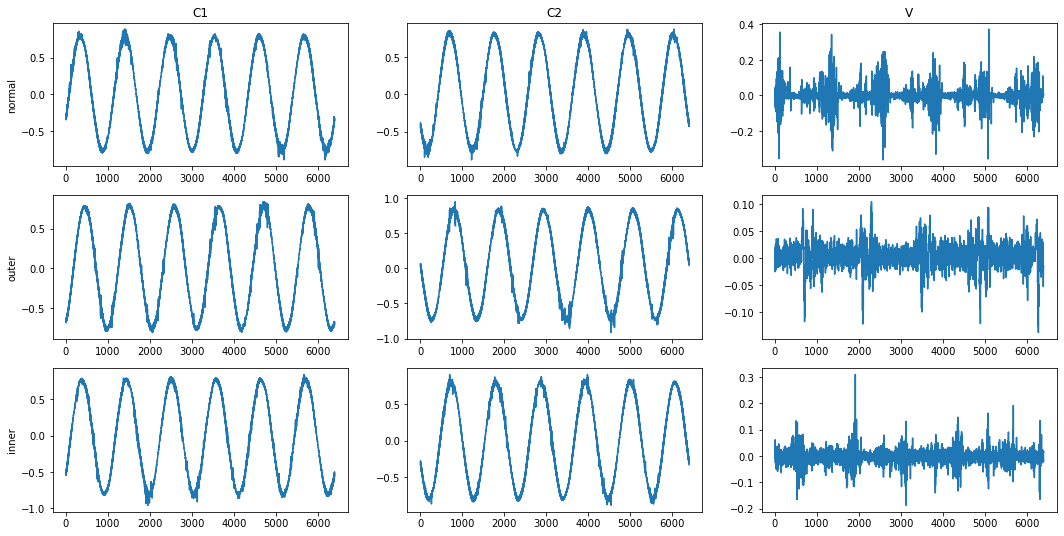

In [9]:
kn = 0
ko = 0
ki = 0
plt.figure(figsize=(18,9))
plt.subplot(331)
plt.plot(normal_data_128[kn,:,0])
plt.ylabel('normal')
plt.title('C1')
plt.subplot(332)
plt.plot(normal_data_128[kn,:,1])
plt.title('C2')
plt.subplot(333)
plt.plot(normal_data_128[kn,:,2])
plt.title('V')

plt.subplot(334)
plt.plot(outer_data_128[ko,:,0])
plt.ylabel('outer')
plt.subplot(335)
plt.plot(outer_data_128[ko,:,1])
plt.subplot(336)
plt.plot(outer_data_128[ko,:,2])

plt.subplot(337)
plt.plot(inner_data_128[ki,:,0])
plt.ylabel('inner')
plt.subplot(338)
plt.plot(inner_data_128[ki,:,1])
plt.subplot(339)
plt.plot(inner_data_128[ki,:,2])
plt.show()

# 构建数据集

In [10]:
'''
状态（3），轴承（5），工况（4），mat（20），样本（40）
所有样本：3*5*4*20*40=48000
一种状态：1*5*4*20*40=16000
一种工况：3*5*1*20*40=12000
'''
M = 80
normal_data = normal_data_128[:,:M*M,:]
outer_data  = outer_data_128[:,:M*M,:]
inner_data  = inner_data_128[:,:M*M,:]

np.random.seed(seed=2021)

def get_ds(bs = 30, m=80, tra_rate=0.8  ):
    '''截取固定长度的信号'''
    window_size = m**2
    print('window_size:  ',window_size)
    normal_data = normal_data_128[:,:window_size,:]
    outer_data  = outer_data_128[:, :window_size,:]
    inner_data  = inner_data_128[:, :window_size,:]
    
    all_data  = np.concatenate([normal_data, outer_data, inner_data])
    all_labels = np.array([0]*len(normal_data) + [1]*len(outer_data) + [2]*len(inner_data))
    print('all_data : ',all_data.shape,all_labels[::500])

    '''样本划分'''
    indexes = np.arange(len(all_data))
    np.random.shuffle(indexes)
    split_num = int(tra_rate*len(all_data))
    
    tra_data   = all_data[indexes[:split_num]]
    tra_labels = all_labels[indexes[:split_num]]
    
    tes_data   = all_data[indexes[split_num:]]
    tes_labels = all_labels[indexes[split_num:]]
    
    print('tra : tes =',len(tra_labels), len(tes_data),sep='\t')
    print(tra_labels[::300],tes_labels[::300])
    
    BUFFER = len(all_data)
    tra_ds = tf.data.Dataset.from_tensor_slices((tra_data,tra_labels)).repeat().shuffle(BUFFER).batch(bs).prefetch(2)
    tes_ds = tf.data.Dataset.from_tensor_slices((tes_data,tes_labels)).repeat().shuffle(BUFFER).batch(bs).prefetch(2)
        
    tra_tes_num = [len(tra_labels),len(tes_data)]
    print('Dataset 准备好了!!!\n')
    return tra_ds,tes_ds, tra_tes_num


tra_ds,tes_ds, tra_tes_num = get_ds( bs = 30, m=M, tra_rate=0.8)


window_size:   6400
all_data :  (3000, 6400, 3) [0 0 1 1 2 2]
tra : tes =	2400	600
[1 1 0 0 0 2 0 1] [2 0]
Dataset 准备好了!!!



In [11]:
tra_tes_num

[2400, 600]

In [12]:
for i,(batch_X,batch_Y) in enumerate(tra_ds):
    print('tra_ds',batch_X.shape,batch_Y.numpy())
    break
    
for i,(X,Y) in enumerate(tra_ds):
    print('tes_ds',X.shape,Y.numpy())
    break


tra_ds (30, 6400, 3) [0 0 2 2 1 0 2 1 1 2 1 2 0 0 0 1 0 1 2 1 1 1 1 1 1 0 2 0 0 1]
tes_ds (30, 6400, 3) [2 1 0 1 1 0 2 2 1 2 1 0 0 1 2 0 0 1 1 0 1 2 2 0 1 1 0 2 0 2]


0 (30, 6400, 3) (30,) [1 0 1 0 0 1 2 0 2 0 1 0 1 0 0 0 1 0 0 1 0 2 0 1 0 0 1 2 1 1]


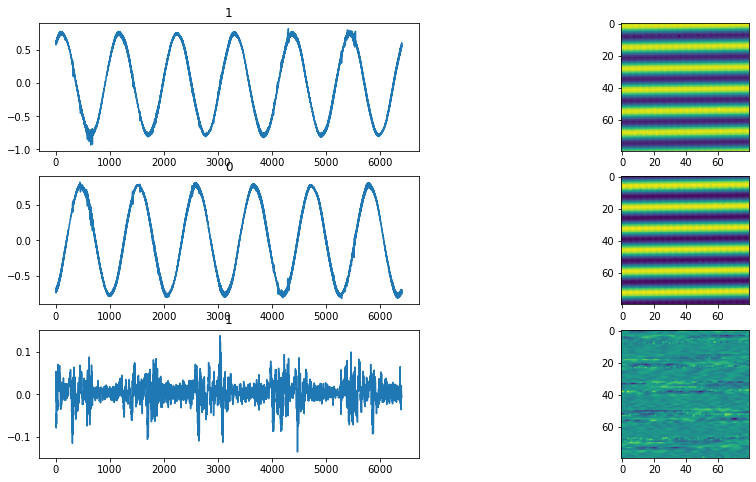

In [13]:
m = 80
for i,(X,Y) in enumerate(tra_ds):
    print(i,X.shape,Y.shape,Y.numpy())
    plt.figure(figsize=(15,8))
    for j in range(3):
        plt.subplot(3,2,2*j+1)
        plt.plot(X[0,:,j])
        plt.title(str(Y[j].numpy()))
        plt.subplot(3,2,2*j+2)
        img = X[0,:,j].numpy().reshape(m,m)
        plt.imshow(img)
    break

# 构建 CNN模型

In [14]:
L = tf.keras.regularizers.L2()
L = None

def Feature_Exacter():
    inputs = tf.keras.Input(shape=  (M*M, 3) , name='inputs')
    x1 = inputs[:,:,:2]
    m = M
    x1  = tf.keras.layers.Reshape((m,m,-1))(x1)
    
    f = [5,10,15,30]
    k = [9,7,5,3]
    s = [1,1,1,1]
    
#     print('inputs,inputs1,inputs2',inputs.shape,inputs1.shape,inputs2.shape)
    ##############################################################################################################
    x1 = tf.keras.layers.Conv2D(f[0],k[0],s[0],activation='relu',padding='same',kernel_regularizer=L,name='x1c1')(x1)
    x1 = tf.keras.layers.MaxPool2D(name='x1p1')(x1)
    
    x1 = tf.keras.layers.Conv2D(f[1],k[1],s[1],activation='relu',padding='same',kernel_regularizer=L,name='x1c2')(x1)
    x1 = tf.keras.layers.MaxPool2D(name='x1p2')(x1)
    
    x1 = tf.keras.layers.Conv2D(f[2],k[2],s[2],activation='relu',padding='same',kernel_regularizer=L,name='x1c3')(x1)
    x1 = tf.keras.layers.MaxPool2D(name='x1p3')(x1)
    
    x1 = tf.keras.layers.Conv2D(f[3],k[3],s[3],activation='relu',padding='same',kernel_regularizer=L,name='x1c4')(x1)
    x1 = tf.keras.layers.MaxPool2D(name='x1p4')(x1)
    
#     x1 = tf.keras.layers.Conv2D(f[4],k[4],s[4],activation='relu',padding='same',kernel_regularizer=L,name='x1c5')(x1)
#     x1 = tf.keras.layers.MaxPool2D(name='x1p5')(x1)
    
    x1 = tf.keras.layers.Flatten(name='Flatten')(x1)
    x1 = tf.keras.layers.Dropout(0.5)(x1)
    model = tf.keras.Model(inputs=inputs, outputs=x1, name='FE')
    return model
FEModel = Feature_Exacter()
FEModel.summary()


# def Header():
#     inputs = tf.keras.Input(shape=(128,),name='inputs')
#     x = tf.keras.layers.Dense(128,activation='sigmoid',name='dense_1')(inputs)
#     x = tf.keras.layers.Dropout(0.2)(x)
#     outputs = tf.keras.layers.Dense(128,activation=None,name='dense_2')(x)
#     model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Header')
#     return model
# HModel = Header()
# HModel.summary()


def Clssfier():
    inputs = tf.keras.Input(shape=(750,),name='inputs')
#     x = tf.keras.layers.Dense(128,activation='relu',name='dense')(inputs)
#     x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(3,activation='softmax',name='softmax')(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=x, name='FE')
    return model
CModel = Clssfier()
CModel.summary()

Model: "FE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 6400, 3)]         0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 6400, 2)           0         
_________________________________________________________________
reshape (Reshape)            (None, 80, 80, 2)         0         
_________________________________________________________________
x1c1 (Conv2D)                (None, 80, 80, 5)         815       
_________________________________________________________________
x1p1 (MaxPooling2D)          (None, 40, 40, 5)         0         
_________________________________________________________________
x1c2 (Conv2D)                (None, 40, 40, 10)        2460      
_________________________________________________________________
x1p2 (MaxPooling2D)          (None, 20, 20, 10)        0        

# 测试

In [15]:
# model_path =  'D:/ML/A_PHD/Bearing_fault_diagnoisis_by_current_signal/code_2021-12-13/temp/工况A/save/'

model_path =  'D:/ML/A_PHD/Bearing_fault_diagnoisis_by_current_signal/code_1-15/temp/工况B不同t-训500（50）/save/'
os.listdir(model_path)

['CCB____1.0____0.0____0.5_R0__TSR0.8__TIME_2022_1_16___0_5___57_6.h5',
 'CCB____1.0____0.0____0.5_R1__TSR0.8__TIME_2022_1_16___5_31___4_6.h5',
 'CCB____1.0____0.0____0.5_R2__TSR0.8__TIME_2022_1_16___10_59___27_6.h5',
 'CCB____1.0____1.0____0.05_R0__TSR0.8__TIME_2022_1_16___0_55___4_6.h5',
 'CCB____1.0____1.0____0.05_R1__TSR0.8__TIME_2022_1_16___6_20___32_6.h5',
 'CCB____1.0____1.0____0.05_R2__TSR0.8__TIME_2022_1_16___11_48___59_6.h5',
 'CCB____1.0____1.0____0.1_R0__TSR0.8__TIME_2022_1_16___1_43___30_6.h5',
 'CCB____1.0____1.0____0.1_R1__TSR0.8__TIME_2022_1_16___7_10___41_6.h5',
 'CCB____1.0____1.0____0.1_R2__TSR0.8__TIME_2022_1_16___12_37___58_6.h5',
 'CCB____1.0____1.0____0.5_R0__TSR0.8__TIME_2022_1_16___2_32___2_6.h5',
 'CCB____1.0____1.0____0.5_R1__TSR0.8__TIME_2022_1_16___8_0___18_6.h5',
 'CCB____1.0____1.0____0.5_R2__TSR0.8__TIME_2022_1_16___13_27___50_6.h5',
 'CCB____1.0____1.0____1.0_R0__TSR0.8__TIME_2022_1_16___3_20___38_6.h5',
 'CCB____1.0____1.0____1.0_R1__TSR0.8__TIME_2022_

In [16]:
FEModel.load_weights(model_path +  'FEB____1.0____0.0____0.5_R0__TSR0.8__TIME_2022_1_16___0_5___57_6.h5')
CModel.load_weights(model_path  +  'CCB____1.0____0.0____0.5_R0__TSR0.8__TIME_2022_1_16___0_5___57_6.h5')

# FEModel.load_weights(model_path +  'FEB____1.0____1.0____0.1_R0__TSR0.8__TIME_2022_1_8___14_12___37_5.h5')
# CModel.load_weights(model_path  +  'CCB____1.0____1.0____0.1_R0__TSR0.8__TIME_2022_1_8___14_12___37_5.h5')

[300, 300, 300]
(500, 6400, 3) (6400,)


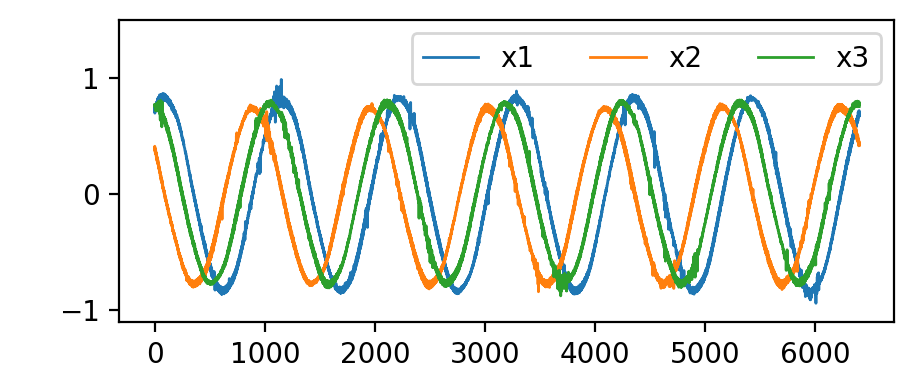

In [17]:
k = [300,300,300]
print(k)
s = 500
sample1 = normal_data[::2]
sample2 = outer_data[::2]
sample3 = inner_data[::2]
print(sample1.shape,sample1[0,:,0].shape)

plt.figure(figsize=(5,2),dpi=200)
plt.plot(sample1[100,:,0],label='x1', linewidth=1)
plt.plot(sample2[200,:,0],label='x2', linewidth=1)
plt.plot(sample3[300,:,0],label='x3', linewidth=1)
plt.legend(ncol=3,loc='upper right')
plt.ylim(-1.1,1.5)
plt.ylabel(' ')

# plt.savefig('x1x2x3.png',bbox_inches ='tight')
plt.show()

-1


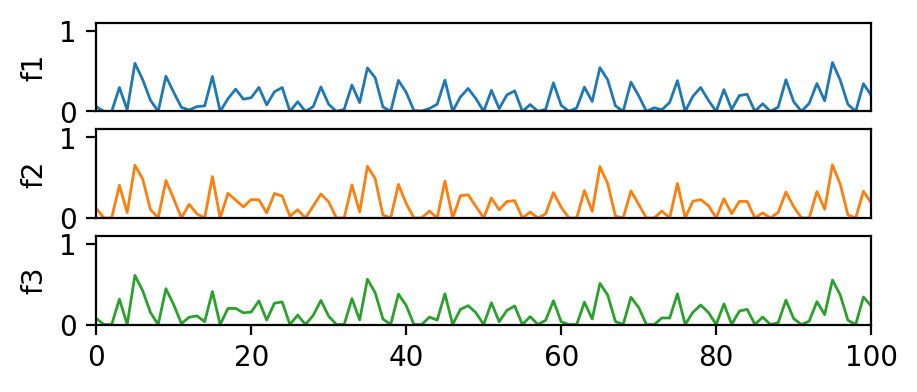

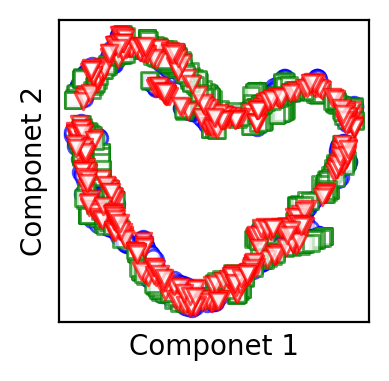

In [18]:
'''训练后'''
from sklearn.manifold import TSNE
def plot_pca(fem_path=-1):
    print(fem_path)
    FEModel = Feature_Exacter()
    if fem_path!=-1:
        FEModel.load_weights(model_path +  fem_path)

    f1 = FEModel.predict(sample1)
    f2 = FEModel.predict(sample2)
    f3 = FEModel.predict(sample3)
    f = [( x/tf.reduce_max(x)).numpy()[0] for x in [f1,f2,f3] ]

    plt.figure(figsize=(5,2),dpi=200)
    plt.subplot(311)
    plt.plot(f[0],label='f1', linewidth=1)
    plt.xticks([])
    plt.ylabel('f1')
    plt.xlim(0,100)
    plt.ylim(0,1.1)

    plt.subplot(312)
    plt.plot([])
    plt.plot(f[1],label='f2', linewidth=1)
    plt.xticks([])
    plt.ylabel('f2')
    plt.xlim(0,100)
    plt.ylim(0,1.1)

    plt.subplot(313)
    plt.plot([])
    plt.plot([])
    plt.plot(f[2],label='f3', linewidth=1)
    plt.ylabel('f3')
    plt.xlim(0,100)
    plt.ylim(0,1.1)
    
    plt.savefig('f1f2f3-'+str(fem_path) + '.png', bbox_inches ='tight')
    plt.show()

    '''特征分布图'''
    X = tf.concat([f1,f2,f3],axis=0).numpy()
    Y = [1]*1000 + [2]*1000 + [3]*1000

    X.shape
    X_tsne = TSNE(learning_rate=100).fit_transform(X)
    
    n = len(X)//3

    plt.figure(figsize=(2,2),dpi=200)
    plt.scatter(X_tsne[:n, 0],     X_tsne[:n, 1],      marker="o",   color='w',  edgecolors='b', label='f1', alpha=0.7 )
    plt.scatter(X_tsne[n:2*n, 0],  X_tsne[n:2*n, 1],   marker="s",   color='w',  edgecolors='g', label='f2', alpha=0.7 )
    plt.scatter(X_tsne[2*n:, 0],   X_tsne[2*n:, 1],    marker="v",   color='w',  edgecolors='r', label='f3', alpha=0.7 )
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Componet 1')
    plt.ylabel('Componet 2')
#     plt.legend(ncol =3)
    plt.savefig('feature-'+str(fem_path) + '.png', bbox_inches ='tight')
    plt.show()
    
plot_pca()    
